In [ ]:
!pip install transformers
!pip install emoji
!pip install contractions
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
dir = '/content/drive/My Drive/1513-project/'

#Preprocess Dataset Used For Fine-tuning

In [ ]:
# Preprocess the data to be used for fine-tuning
import pandas as pd
headers = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(dir + 'labeled_tweets.csv', encoding='ISO-8859-1', header=None, names=headers)
print(df.head())

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [ ]:
import pandas as pd
headers = ['tweet', 'language']
df = pd.read_csv(dir + 'us_election-edit.csv', encoding='ISO-8859-1', usecols=headers, lineterminator='\n')
df = df[df['language'] == 'en']
df = df.rename(columns={'tweet': 'text'})
print(df.head())

                                                text language
0  Hi if you want Americans to infuriate you in t...       en
1  @armstrongcbc No surprise. It's going to be a ...       en
2  I canât wait till after the US election so I...       en
3  America as a foreign country, by foreign corre...       en
4  Wow. I guess if you want actual journalism and...       en


In [ ]:
import emoji
import re
import contractions
def preprocess_data_cleaning(df):
  # First we lower case the data
  df['text_cleaned'] = df['text'].apply(lambda x: x.lower())
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'(http\S+|www\.\S+)', '', regex=True) # Remove url
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'<.*?>', '', regex=True) # remove html tags
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: emoji.demojize(x)) # remove emojis
  df['text_cleaned'] = df['text_cleaned'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True) # remove special characters
  df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x)) # Fix contractions

  return df

def rename_label(df):
  label_map = {0:0, 2:1, 4:2}
  df['target'] = df['target'].map(label_map)
  df = df.rename(columns={'target': 'label'})

  return df

In [ ]:
import pandas as pd
# df = preprocess_data_cleaning(df)
# df = rename_label(df)
# print(df.head())
df = preprocess_data_cleaning(df)

print(df.head())

                                                text language  \
0  Hi if you want Americans to infuriate you in t...       en   
1  @armstrongcbc No surprise. It's going to be a ...       en   
2  I canât wait till after the US election so I...       en   
3  America as a foreign country, by foreign corre...       en   
4  Wow. I guess if you want actual journalism and...       en   

                                        text_cleaned  
0  hi if you want americans to infuriate you in t...  
1  armstrongcbc no surprise its going to be a vol...  
2  i cannot wait till after the us election so i ...  
3  america as a foreign country by foreign corres...  
4  wow i guess if you want actual journalism and ...  


# Pseudo Label and Tokenize Dataset

In [ ]:
from datasets import Dataset

# Load the pd frame into dataset to allow for batch processing
dataset = Dataset.from_pandas(df)
# dataset = dataset.remove_columns(['ids', 'date', 'flag', 'user', 'text'])
dataset = dataset.remove_columns(['text', 'language'])
print(dataset[0:5])

{'text_cleaned': ['hi if you want americans to infuriate you in the comments not realise the whole world does not vote in the us election and not know that ireland is not in britain this is the thread for you', 'armstrongcbc no surprise its going to be a volatile few weeks in the market what with the uselection and a lot more earnings results to come', 'i cannot wait till after the us election so i can make fun of the trump supporters and remind trump every day that he is a loser', 'america as a foreign country by foreign correspondents covering the us election  ', 'wow i guess if you want actual journalism and real coverage of the us election going to have to start watching skynewsaust whoever says the media in the us is not biased is just trying to be blind to the facts at this point   '], '__index_level_0__': [0, 1, 2, 3, 4]}


In [ ]:
from textblob import TextBlob

def get_pseudo_label(data):
    # Compute sentiment polarity to use as label
    polarity = TextBlob(data['text_cleaned']).sentiment.polarity
    # Define thresholds to assign a label:
    # For instance, label 2 for positive, 0 for negative, and 1 for neutral
    if polarity > 0.1:
        label = 2
    elif polarity < -0.1:
        label = 0
    else:
        label = 1
    return {"label": label}

# Apply the function to add a new column with pseudo-labels
dataset = dataset.map(get_pseudo_label)
print(dataset[0:5])

Map:   0%|          | 0/124586 [00:00<?, ? examples/s]

{'text_cleaned': ['hi if you want americans to infuriate you in the comments not realise the whole world does not vote in the us election and not know that ireland is not in britain this is the thread for you', 'armstrongcbc no surprise its going to be a volatile few weeks in the market what with the uselection and a lot more earnings results to come', 'i cannot wait till after the us election so i can make fun of the trump supporters and remind trump every day that he is a loser', 'america as a foreign country by foreign correspondents covering the us election  ', 'wow i guess if you want actual journalism and real coverage of the us election going to have to start watching skynewsaust whoever says the media in the us is not biased is just trying to be blind to the facts at this point   '], '__index_level_0__': [0, 1, 2, 3, 4], 'label': [2, 2, 2, 0, 1]}


In [ ]:
from transformers import AutoTokenizer

# Load the BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)

# Function to tokenize the text in batches
def tokenize(text_batch, tokenizer):
  return tokenizer(
    text_batch['text_cleaned'],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="pt"
  )

In [ ]:
# Tokenize the cleaned text data in batches
tokenized_dataset = dataset.map(lambda x: tokenize(x, tokenizer), batched=True)
tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
print(tokenized_dataset[0])

Map:   0%|          | 0/124586 [00:00<?, ? examples/s]

{'label': tensor(2), 'input_ids': tensor([    0,   860,    65,    14,    96, 29849,     9, 53962,   760,    14,
           16,     6,  2532,    46,  4614,     6,   434,   220,   158,    46,
          759,    16,     6,   148,  1843,    13,    46,    68,    25, 35183,
           17,    46,    16, 50867,    33,    17,     6,  3966,    19,    14,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(["__index_level_0__"])
print(tokenized_dataset)

Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 124586
})


In [ ]:
subset_tokenized_dataset = tokenized_dataset.shuffle(seed=39).select(range(30000))
print(subset_tokenized_dataset)

Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30000
})


# Finetune BERTweet

In [ ]:
# Split the subset of the tokenized dataset into train and test set with a 80/20 split
split_tokenized_dataset = subset_tokenized_dataset.train_test_split(test_size=0.2)
train_tokenized_dataset = split_tokenized_dataset['train']
test_tokenized_dataset = split_tokenized_dataset['test']
# train_tokenized_dataset = tokenized_dataset['train']
# test_tokenized_dataset = tokenized_dataset['test']

print(train_tokenized_dataset)
print(test_tokenized_dataset)

print(train_tokenized_dataset.unique("label"))
print(test_tokenized_dataset.unique("label"))

Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 24000
})
Dataset({
    features: ['text_cleaned', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6000
})


Flattening the indices:   0%|          | 0/24000 [00:00<?, ? examples/s]

[1, 2, 0]


Flattening the indices:   0%|          | 0/6000 [00:00<?, ? examples/s]

[2, 1, 0]


In [ ]:
import os
from transformers import AutoModelForSequenceClassification

# Get the pretrained model - Bertweet
if os.path.exists(os.path.join(dir + 'bertweet3/final_model/config.json')) and os.path.exists(os.path.join(dir + 'bertweet3/final_model/model.safetensors')):
  print('Already fine-tuned!')
  model = AutoModelForSequenceClassification.from_pretrained(dir + 'bertweet3/final_model', num_labels=3)
else:
  model = AutoModelForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Define a metric to use during fine-tuning
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

# Define the training arguments to finetune the pretrained model
training_args = TrainingArguments(
    output_dir=dir+'bertweet3',
    run_name='Bertweet3 finetune',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir=dir+'bertweet3/logs',
    learning_rate=4e-5
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics
)

# Start finetuning the pretrained model
trainer.train()

# Save the model after training
model.save_pretrained(dir+'bertweet3/final_model')
tokenizer.save_pretrained(dir+'bertweet3/tokenizer')

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.639200,0.718171,0.708167,0.656100
2,0.307900,0.286873,0.901167,0.900337
3,0.207100,0.253052,0.922167,0.922271


('/content/drive/My Drive/1513-project/bertweet3/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/vocab.txt',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/bpe.codes',
 '/content/drive/My Drive/1513-project/bertweet3/tokenizer/added_tokens.json')

# Preprocess Election Dataset

In [ ]:
import os
import glob
import pandas as pd
import datetime

In [ ]:
start_date = datetime.date(2024, 5, 1)
end_date = datetime.date(2024, 11, 30)
delta = datetime.timedelta(days=1)

files_to_download = []
current = start_date
while current <= end_date:
    files_to_download.append(current.strftime("%Y-%m-%d"))
    current += delta

print(files_to_download)

path_to_download = dir + 'election_data'

!mkdir -p '{path_to_download}'

final_csv_filename = 'combined_daily_dataset.csv'
if not os.path.exists(os.path.join(path_to_download, final_csv_filename)):
  dfs = []
  for file in files_to_download:
    url = f"https://github.com/YupengHuangFrank/ECE1513/raw/refs/heads/main/Date-Ordered-Data/{file}.csv.gz"
    filename = file + '.csv.gz'
    try:
      single_df = pd.read_csv(url, compression='gzip', usecols=['text', 'epoch'])
      n_samples = min(2000, len(single_df))
      sample_df = single_df.sample(n=n_samples, random_state=39)
      dfs.append(sample_df)
      print(f"Processed {filename}: sampled {n_samples} rows.")
    except Exception as e:
      print(f"Error processing csv {filename}: {e}")

  combined_df = pd.concat(dfs, ignore_index=True)
  # Save the combined DataFrame to csv for future load
  combined_file = os.path.join(path_to_download, final_csv_filename)
  combined_df.to_csv(combined_file, index=False)
  print(f"Combined csv saved at: {combined_file}")
else:
  print('Already combined, read from existing csv!')

print(combined_df)

['2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-11', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09', '2024-07-10', '2024

In [ ]:
# Now preprocess the combined election dataset
combined_df = preprocess_data_cleaning(combined_df)
print(combined_df)

                                                     text         epoch  \
0       Trump rolls out the red carpet for foreign lea...  1.714602e+09   
1       Donald Trump Takes Biggest Lead Ever over Joe ...  1.714604e+09   
2       @PhonyLyingLibs @obriedave1 @DebraSc69769469 @...  1.714602e+09   
3       Democrats: BAGS - Biden And Gullible Supporter...  1.714600e+09   
4       @WhitneyChanell @AlmaSuono Not sure what there...  1.714595e+09   
...                                                   ...           ...   
369767  @truckdriverpleb He managed to outdo himself. ...  1.732961e+09   
369768  @Benioff how much lower are twitter's revenues...  1.733004e+09   
369769  @RangerUpCoffee Occam's razor.  the simplest e...  1.733006e+09   
369770  Donald Trump’s pick for Treasury secretary has...  1.732990e+09   
369771  @MdBreathe Republicans turned out all women to...  1.732949e+09   

                                             text_cleaned  
0       trump rolls out the red carpet 

# Tokenize Election Dataset

In [ ]:
from datasets import Dataset
# Load the election df into dataset to allow for batch processing
combined_election_dataset = Dataset.from_pandas(combined_df)
combined_election_dataset = combined_election_dataset.remove_columns(['text'])
print(combined_election_dataset[0:5])

{'epoch': [1714601618.0, 1714603996.0, 1714602308.0, 1714599951.0, 1714595435.0], 'text_cleaned': ['trump rolls out the red carpet for foreign leaders irking biden allies  via nbcnews', 'donald trump takes biggest lead ever over joe biden in cnn poll thirdparty candidates expand trump lead\n', 'phonylyinglibs obriedave1 debrasc69769469 retusafmsgt repmtg him in office after he lost to joe biden', 'democrats bags  biden and gullible supporters ', 'whitneychanell almasuono not sure what there is too not like  equal rights for black people minorities amp lgbtq comm or womens rights or the most diverse judicial appts ever womanshruggingmediumskintone\ni am sure you will not have to hang out with him i just need him to continue being the most progressive potus of our lifetimes']}


In [ ]:
from transformers import AutoTokenizer

# Now we tokenize the combined election dataset
# Load the BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained(dir + 'bertweet3/tokenizer', use_fast=False)

# Function to tokenize the text in batches
def tokenize(text_batch, tokenizer):
  return tokenizer(
    text_batch['text_cleaned'],
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors="pt"
  )

In [ ]:
# Tokenize the cleaned text data in batches
tokenized_election_dataset = combined_election_dataset.map(lambda x: tokenize(x, tokenizer), batched=True)
tokenized_election_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])
print(tokenized_election_dataset[0])
print(tokenized_election_dataset)

Map:   0%|          | 0/369772 [00:00<?, ? examples/s]

{'input_ids': tensor([    0,  3377,  6563,    50,     6,  1007, 10160,    19,  3923,  3164,
         1784,  1235,   607, 22042, 15456,   156,   608, 21337,   615,     2,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

# Sentiment Prediction

In [ ]:
# Load the model that we fine-tuned and use it to predict for the new dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(dir + 'bertweet3/final_model')

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# Create a DataLoader from the tokenized dataset
election_dataloader = DataLoader(tokenized_election_dataset, batch_size=64)

model.eval()  # Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

with torch.no_grad():
    for batch in tqdm(election_dataloader, desc="Predicting"):
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)
        predictions.extend(batch_predictions.tolist())

print(predictions)

In [ ]:
# Associate each prediction with its corresponding row
tokenized_election_dataset.reset_format()
tokenized_election_dataset = tokenized_election_dataset.add_column("prediction", predictions)
print(tokenized_election_dataset[3])
unique_values = tokenized_election_dataset.unique('prediction')
print(unique_values)

{'epoch': 1714599951.0, 'text_cleaned': 'democrats bags  biden and gullible supporters ', 'input_ids': [0, 13410, 4572, 607, 22042, 13, 29619, 4959, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# Save the prediction
prediction_df = tokenized_election_dataset.to_pandas()
# prediction_df.to_csv(dir + 'election_data/election_prediction_data1.csv', columns=['epoch', 'text_cleaned', 'prediction'], index=False)

In [ ]:
# We will associate each tweet with a candidate first
def detect_candidate(text):
    text = text.lower()
    group1 = ['joe', 'biden', 'kamala', 'harris']
    group2 = ['donald', 'trump']
    if any(name in text for name in group1) and any(name in text for name in group2):
      group1_indices = [text.find(name) for name in group1 if text.find(name) != -1]
      group2_indices = [text.find(name) for name in group2 if text.find(name) != -1]
      if min(group1_indices) < min(group2_indices):
        return 'biden-kamala'
      else:
        return 'trump'
    elif any(name in text for name in group1):
      return 'biden-kamala'
    elif any(name in text for name in group2):
      return 'trump'
    else:
      return 'other'

In [ ]:
prediction_df['candidate'] = prediction_df['text_cleaned'].apply(detect_candidate)

print(prediction_df.head())

          epoch                                       text_cleaned  \
0  1.714602e+09  trump rolls out the red carpet for foreign lea...   
1  1.714604e+09  donald trump takes biggest lead ever over joe ...   
2  1.714602e+09  phonylyinglibs obriedave1 debrasc69769469 retu...   
3  1.714600e+09     democrats bags  biden and gullible supporters    
4  1.714595e+09  whitneychanell almasuono not sure what there i...   

                                           input_ids  \
0  [0, 3377, 6563, 50, 6, 1007, 10160, 19, 3923, ...   
1  [0, 21196, 3377, 956, 1345, 1225, 179, 141, 10...   
2  [0, 10472, 460, 1747, 856, 24435, 4363, 48712,...   
3  [0, 13410, 4572, 607, 22042, 13, 29619, 4959, ...   
4  [0, 11427, 11558, 16433, 3197, 638, 879, 1692,...   

                                      token_type_ids  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0,

In [ ]:
prediction_df['datetime'] = pd.to_datetime(prediction_df['epoch'], unit='s')
prediction_df.sort_values('datetime', inplace=True)
prediction_df.set_index('datetime', inplace=True)
print(prediction_df.head())

                            epoch  \
datetime                            
2024-05-01 00:00:43  1.714522e+09   
2024-05-01 00:01:46  1.714522e+09   
2024-05-01 00:02:36  1.714522e+09   
2024-05-01 00:03:47  1.714522e+09   
2024-05-01 00:12:34  1.714522e+09   

                                                          text_cleaned  \
datetime                                                                 
2024-05-01 00:00:43  meme generated by opossumal opsmcrypto \nopsm ...   
2024-05-01 00:01:46  trump 2024 \n\ndecencyisontheballot\ntrump2024...   
2024-05-01 00:02:36  president biden received such poor coverage th...   
2024-05-01 00:03:47  if joe biden becomes president again in novemb...   
2024-05-01 00:12:34  any of my clients who acted even remotely like...   

                                                             input_ids  \
datetime                                                                 
2024-05-01 00:00:43  [0, 6986, 17688, 61, 2084, 13342, 1692, 7774, ...   

In [ ]:
# Define the mapping from sentiment to popularity score
sentiment_to_popularity = {0: -1, 1: 0, 2: 1}

# Map the predictions to a new column 'popularity_score'
prediction_df["popularity_score"] = prediction_df["prediction"].map(sentiment_to_popularity)

print(prediction_df.head())

                            epoch  \
datetime                            
2024-05-01 00:00:43  1.714522e+09   
2024-05-01 00:01:46  1.714522e+09   
2024-05-01 00:02:36  1.714522e+09   
2024-05-01 00:03:47  1.714522e+09   
2024-05-01 00:12:34  1.714522e+09   

                                                          text_cleaned  \
datetime                                                                 
2024-05-01 00:00:43  meme generated by opossumal opsmcrypto \nopsm ...   
2024-05-01 00:01:46  trump 2024 \n\ndecencyisontheballot\ntrump2024...   
2024-05-01 00:02:36  president biden received such poor coverage th...   
2024-05-01 00:03:47  if joe biden becomes president again in novemb...   
2024-05-01 00:12:34  any of my clients who acted even remotely like...   

                                                             input_ids  \
datetime                                                                 
2024-05-01 00:00:43  [0, 6986, 17688, 61, 2084, 13342, 1692, 7774, ...   

In [ ]:
prediction_df["popularity_score"] = pd.to_numeric(prediction_df["popularity_score"], errors="coerce")
prediction_df.dropna(subset=["popularity_score"], inplace=True)
popularity_over_time = prediction_df.groupby("candidate")["popularity_score"].resample("D").mean()
print(popularity_over_time)

candidate     datetime  
biden-kamala  2024-05-01    0.069380
              2024-05-02    0.074315
              2024-05-03    0.060241
              2024-05-04    0.036158
              2024-05-05    0.058897
                              ...   
trump         2024-11-26    0.113300
              2024-11-27    0.216216
              2024-11-28    0.150235
              2024-11-29    0.118605
              2024-11-30    0.181360
Name: popularity_score, Length: 642, dtype: float64


In [ ]:
num_groups = len(popularity_over_time.index.get_level_values('candidate').unique())
print("Number of groups:", num_groups)

Number of groups: 3


In [ ]:
popularity_df = popularity_over_time.reset_index()
popularity_pivot = popularity_df.pivot(index="datetime", columns="candidate", values="popularity_score")
popularity_pivot = popularity_pivot.drop("other", axis=1)
print(popularity_pivot)

candidate   biden-kamala     trump
datetime                          
2024-05-01      0.069380  0.182584
2024-05-02      0.074315  0.130435
2024-05-03      0.060241  0.113043
2024-05-04      0.036158  0.144201
2024-05-05      0.058897  0.021164
...                  ...       ...
2024-11-26      0.046062  0.113300
2024-11-27      0.022086  0.216216
2024-11-28      0.134851  0.150235
2024-11-29      0.085455  0.118605
2024-11-30      0.095517  0.181360

[214 rows x 2 columns]


In [ ]:
def compute_relative_percentage(row):
    # # Transform raw scores from [-1, 1] to [0, 1]
    biden_pop_score = row['biden-kamala']
    trump_score = row['trump']
    # other_score = row['other']

    biden_pop_score_normalized = (biden_pop_score + 1) / 2
    trump_score_normalized = (trump_score + 1) / 2
    # other_score_normalized = (other_score + 1 ) / 2

    # total = biden_pop_score_normalized + trump_score_normalized + other_score_normalized
    total = biden_pop_score_normalized + trump_score_normalized
    biden_relative_percentage = (biden_pop_score_normalized / total) * 100
    trump_relative_percentage = (trump_score_normalized / total) * 100
    # other_relative_percentage = (other_score_normalized / total) * 100

    row['biden-kamala'] = biden_relative_percentage
    row['trump'] = trump_relative_percentage
    # row['other'] = other_relative_percentage

# Apply the function row-wise
popularity_pivot.apply(compute_relative_percentage, axis=1)

print(popularity_pivot)

candidate   biden-kamala      trump
datetime                           
2024-05-01     47.486534  52.513466
2024-05-02     48.727288  51.272712
2024-05-03     48.785191  51.214809
2024-05-04     47.522370  52.477630
2024-05-05     50.907022  49.092978
...                  ...        ...
2024-11-26     48.443104  51.556896
2024-11-27     45.663447  54.336553
2024-11-28     49.663391  50.336609
2024-11-29     49.247976  50.752024
2024-11-30     48.114882  51.885118

[214 rows x 2 columns]


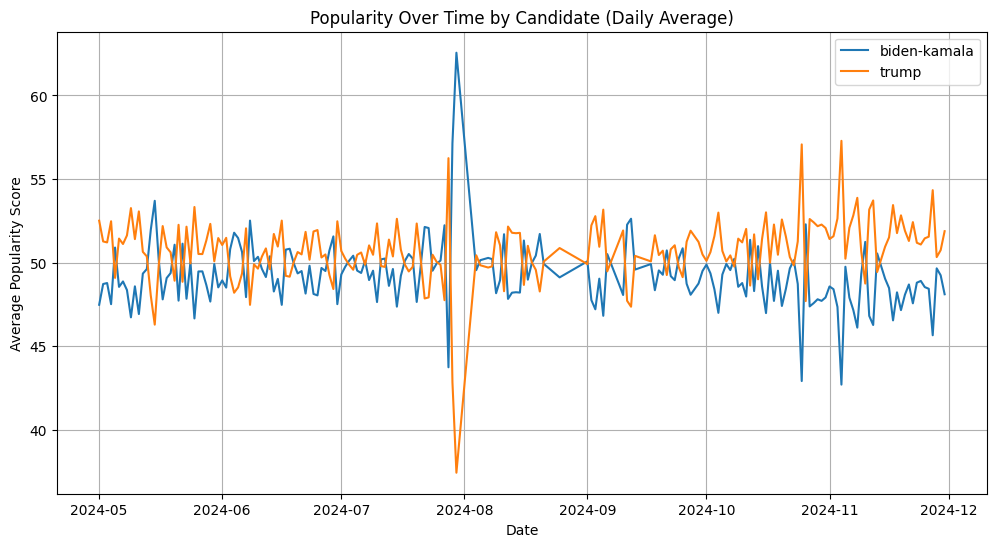

In [ ]:
import matplotlib.pyplot as plt

popularity_pivot_new_interpolated = popularity_pivot.interpolate(method='linear')

plt.figure(figsize=(12, 6))
for candidate in popularity_pivot_new_interpolated.columns:
    plt.plot(popularity_pivot_new_interpolated.index, popularity_pivot_new_interpolated[candidate], label=candidate)
plt.title("Popularity Over Time by Candidate (Daily Average)")
plt.xlabel("Date")
plt.ylabel("Average Popularity Score")
plt.legend()
plt.grid(True)
plt.show()